In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from ast import literal_eval

import re
import string
import pprint

In [2]:
# from nltk.tokenize import word_tokenize
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# from nltk.tag import pos_tag
# from nltk.chunk import ne_chunk

In [4]:
# import spacy
# from rake_nltk import Rake

In [5]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Phrases
from gensim import corpora, similarities
from gensim.models import TfidfModel, LsiModel, LdaModel, RpModel, HdpModel
from gensim.models.coherencemodel import CoherenceModel

In [6]:
# from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer

In [7]:
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler

In [8]:
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

In [9]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

## 1) Read in the data

In [10]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)
print(movies.shape)
movies.head()

(47723, 8)


,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"['tom_hanks', 'tim_allen', 'don_rickles', 'jim..."
1,2,8844,113497,Jumanji,"['Adventure', 'Children', 'Fantasy']",When siblings Judy and Peter discover an encha...,joe_johnston,"['robin_williams', 'kirsten_dunst', 'bradley_p..."
2,3,15602,113228,Grumpier Old Men,"['Comedy', 'Romance']",A family wedding reignites the ancient feud be...,howard_deutch,"['walter_matthau', 'jack_lemmon', 'ann-margret..."
3,4,31357,114885,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"['whitney_houston', 'angela_bassett', 'loretta..."
4,5,11862,113041,Father of the Bride Part II,['Comedy'],Just when George Banks has recovered from his ...,charles_shyer,"['steve_martin', 'diane_keaton', 'martin_short..."


#### Lists in columns got turned into text strings during save to csv; need to undo that

In [11]:
movies['genres'] = movies['genres'].map(literal_eval)
movies['actors'] = movies['actors'].map(literal_eval)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]"
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce..."
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop..."
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi..."
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim..."


## 2) Tokenize the 'overview' column

#### Use Gensim to do this

In [16]:
stemmer = PorterStemmer()

# movies['plot_tokens'] = stemmer.stem_documents(movies['overview'])
movies['plot_tokens'] = ''
for n, row in movies.iterrows():
#     processed = simple_preprocess(remove_stopwords(row['plot_tokens'], stopwords=STOPWORDS), min_len=2, deacc=True)
    processed = simple_preprocess(remove_stopwords(row['overview'], stopwords=STOPWORDS), min_len=2, deacc=True)
    movies.at[n,'plot_tokens'] = list(set(processed))

In [17]:
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]","[brings, duo, afraid, lightyear, room, scene, ..."
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...","[siblings, door, invite, room, judy, evil, enc..."
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...","[italian, sultry, local, door, buddies, john, ..."
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...","[robin, way, determined, stepped, out, bernie,..."
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...","[will, pregnant, plan, grandchild, news, daugh..."


In [51]:
# Add bigrams & trigrams to plot_tokens (only ones that appear 20 times or more)

bigram = Phrases(movies['plot_tokens'], min_count=20)
trigram = Phrases(bigram[movies['plot_tokens']], min_count=20)

for idx in range(len(movies['plot_tokens'])):
    for token in trigram[movies['plot_tokens'][idx]]:
        if '_' in token:
            # Token is a bigram or trigram, add to document
            movies['plot_tokens'][idx].append(token)

In [58]:
movies['genres'] = movies['genres'].map(lambda x: [el.lower() for el in x])

In [59]:
movies['director'] = movies['director'].map(lambda x: [x])

#### Combine all tokens into one 'corpus' column

In [60]:
cols = ['genres', 'director', 'actors', 'plot_tokens']

movies['corpus'] = ''

for n, row in movies.iterrows():
    val = ''
    for col in cols:
        val += ' '.join(row[col])
        val += ' '
    movies.at[n,'corpus'] = val

In [61]:
movies['corpus'] = movies['corpus'].map(lambda x: list(set(x.split())))
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[birthdai, hi, place, heart, circumst, led, li...","[birthdai, hi, place, heart, circumst, led, li..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[judi, open, game, creatures, world, peter, in...","[judi, open, game, creatures, world, peter, on..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[max, open, next, time, bait, she, shop, alarm...","[max, open, next, time, bait, ann-margret, sop..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[break, stellar, lovers, string, step, vannah,...","[break, stellar, drama, lovers, string, step, ..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[hi, wedding, pregnant, arriv, that, plan, lik...","[hi, wedding, pregnant, arriv, that, plan, lik..."


In [62]:
movies['corpus'][0]

['birthdai',
 'hi',
 'place',
 'heart',
 'circumst',
 'led',
 'lightyear',
 'eventu',
 'plot',
 'differences',
 'lose',
 'toi',
 'tom_hanks',
 'don_rickles',
 'andy',
 'separ',
 'afraid',
 'woodi',
 'comedy',
 'john_lasseter',
 'jim_varney',
 'animation',
 'adventure',
 'tim_allen',
 'happili',
 'live',
 'room',
 'fantasy',
 'owner',
 'bring',
 'learn',
 'birthdai_hi',
 'scene',
 'buzz',
 'woody',
 'duo',
 'asid',
 'children']

#### Convert from corpus to list of vectors

In [63]:
dictionary = corpora.Dictionary(list(movies['corpus']))
print(dictionary)

Dictionary(149640 unique tokens: ['adventure', 'afraid', 'andy', 'animation', 'asid']...)


In [64]:
bag_of_words = [dictionary.doc2bow(text) for text in list(movies['corpus'])]

In [65]:
tfidf = TfidfModel(bag_of_words)
corpus_tfidf = tfidf[bag_of_words]

In [66]:
def compute_coherences(corpus_tfidf, dictionary, num_topics_list):
    coherences = []
    for num in num_topics_list:
        print('Computing coherence for {} topics...'.format(num))
        coherences.append(CoherenceModel(model=LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=num),
                                         corpus=corpus_tfidf,
                                         dictionary=dictionary,
                                         coherence='u_mass').get_coherence()
                         )
        print('   Coherence: {}'.format(coherences[-1]))
    return coherences

#### Use Coherence to determine how many topics to model (lower Coherence value is better)

In [67]:
num_topics_list = [50, 100, 200, 300, 400, 500, 750, 1000, 1500, 2000, 2250, 2500, 2750, 3000]
coherences = compute_coherences(corpus_tfidf, dictionary, num_topics_list)

Computing coherence for 50 topics...
   Coherence: -3.0864423386672724
Computing coherence for 100 topics...
   Coherence: -3.2440962271311906
Computing coherence for 200 topics...
   Coherence: -3.401095758952041
Computing coherence for 300 topics...
   Coherence: -3.6817658238091138
Computing coherence for 400 topics...
   Coherence: -3.8541823015714045
Computing coherence for 500 topics...
   Coherence: -4.083042076416938
Computing coherence for 750 topics...
   Coherence: -4.831496667439698
Computing coherence for 1000 topics...
   Coherence: -5.796992913586486
Computing coherence for 1500 topics...
   Coherence: -8.030959967163513
Computing coherence for 2000 topics...
   Coherence: -9.870510404257537
Computing coherence for 2250 topics...
   Coherence: -10.691509169876827
Computing coherence for 2500 topics...
   Coherence: -11.346609870946748
Computing coherence for 2750 topics...
   Coherence: -11.946929364827417
Computing coherence for 3000 topics...
   Coherence: -12.47121447

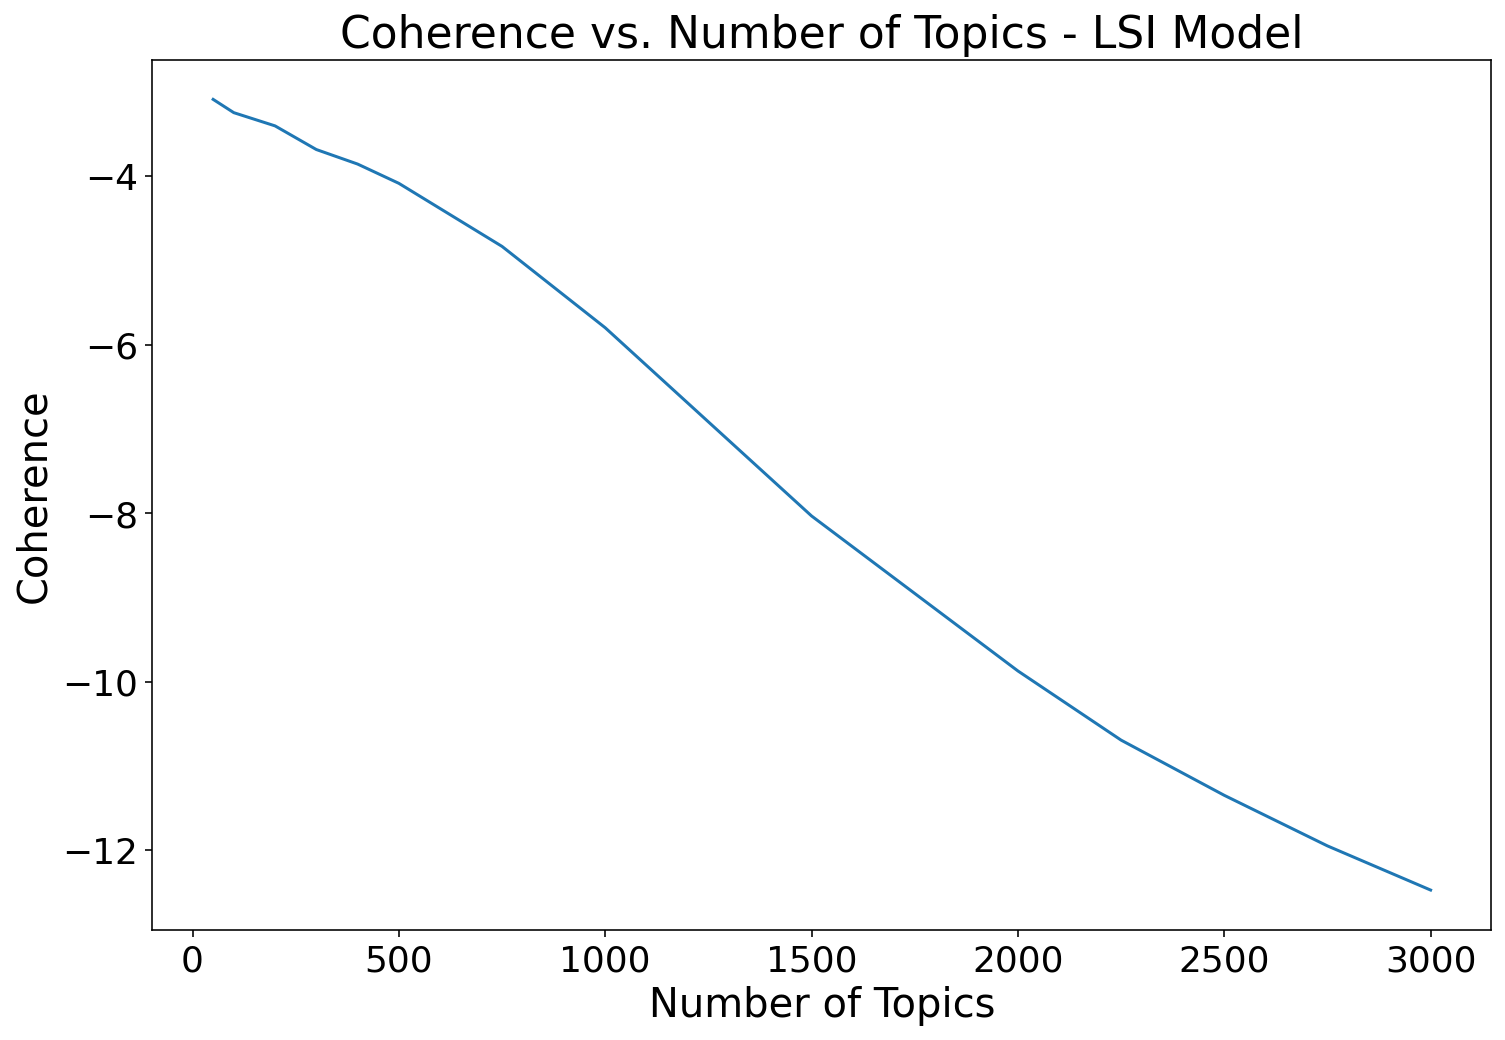

In [68]:
plt.figure(figsize=(12, 8))
plt.plot(num_topics_list, coherences)
plt.title('Coherence vs. Number of Topics - LSI Model', size=22)
plt.xlabel('Number of Topics', size=20)
plt.ylabel('Coherence', size=20)
plt.xticks(size=18)
plt.yticks(size=18);

In [69]:
## Use LSI to reduce dimensionality (just using tfidf causes an out-of-memory condition upon similarity lookkup)

lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=3000)

In [70]:
for n in range(0, lsi.num_topics-1):
    print('Topic # {}: {}'.format(n, lsi.print_topic(n)))

Topic # 0: 0.141*"hi" + 0.132*"comedy" + 0.130*"drama" + 0.126*"thriller" + 0.122*"ha" + 0.119*"thei" + 0.117*"romance" + 0.114*"young" + 0.113*"ar" + 0.112*"action"
Topic # 1: 0.302*"thriller" + 0.266*"action" + 0.248*"crime" + -0.215*"romance" + -0.194*"love" + 0.184*"horror" + 0.174*"murder" + 0.168*"mystery" + 0.165*"sci-fi" + -0.131*"comedy"
Topic # 2: -0.245*"crime" + 0.234*"adventure" + 0.185*"sci-fi" + -0.184*"murder" + -0.182*"thriller" + -0.180*"mystery" + 0.180*"war" + 0.174*"world" + 0.151*"documentary" + 0.150*"animation"
Topic # 3: 0.310*"horror" + -0.239*"crime" + -0.215*"war" + 0.176*"sci-fi" + -0.161*"documentary" + 0.156*"children" + -0.153*"film" + 0.138*"fantasy" + -0.136*"stori" + -0.116*"romance"
Topic # 4: -0.294*"documentary" + 0.234*"adventure" + -0.229*"film" + 0.224*"action" + -0.205*"horror" + 0.180*"romance" + -0.174*"documentari" + -0.146*"mystery" + 0.133*"fall" + -0.132*"thi"
Topic # 5: 0.276*"woman" + 0.219*"war" + 0.217*"young" + 0.197*"horror" + 0.190

#### Compute cosine similarities

In [71]:
## sim_index = similarities.SparseMatrixSimilarity(tfidf[bag_of_words], num_terms=movies.shape[0])

sim_index = similarities.SparseMatrixSimilarity(lsi[bag_of_words], num_terms=movies.shape[0])

In [72]:
def recommend(movie_id, len=20):
    movie_idx = movies[movies['movieId'] == movie_id].index[0]
    rec_indices = sim_index[lsi[dictionary.doc2bow(movies['corpus'][movie_idx])]].argsort()[::-1][0:len+1]
    rec_indices = [rec_idx for rec_idx in rec_indices if rec_idx != movie_idx]
    print('Recommendations based on your interest in {}:'
               .format(movies[movies['movieId'] == movie_id]['title'].values[0]))
    recommendations = movies.iloc[rec_indices, np.r_[3:5, 6:8]]
    recommendations['relevancy'] = sim_index[lsi[dictionary.doc2bow(movies['corpus'][movie_idx])]][rec_indices]
    return recommendations

In [73]:
## This is what LSI w/ tri-grams & 3000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.524748
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.454599
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.445177
24407,Partysaurus Rex,"[animation, children, comedy]",[mark_a._walsh],"[wallace_shawn, tom_hanks, tim_allen, corey_bu...",0.399672
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.366384
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.365800
10642,The Wild,"[adventure, animation, children, comedy, fantasy]",[steve_'spaz'_williams],"[kiefer_sutherland, jim_belushi, eddie_izzard,...",0.310556
11635,Underdog,"[action, adventure, children, comedy, fantasy,...",[frederik_du_chau],"[jason_lee, jim_belushi, patrick_warburton, jo...",0.300439
2173,A Bug's Life,"[adventure, animation, children, comedy]",[john_lasseter],"[dave_foley, kevin_spacey, julia_louis-dreyfus...",0.296831
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.292178


In [50]:
## This is what LSI w/ bi-grams & 3000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.533800
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.459625
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.437878
24407,Partysaurus Rex,"[animation, children, comedy]",[mark_a._walsh],"[wallace_shawn, tom_hanks, tim_allen, corey_bu...",0.375760
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.372603
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.340067
11812,Valhalla,"[adventure, animation, children, fantasy]",[peter_madsen],"[dick_kaysø, preben_kristensen, laura_bro, mar...",0.304373
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.290508
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.289554
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.288863


In [27]:
## This is what LSI w/ 3000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.540007
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.455541
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.441024
24407,Partysaurus Rex,"[animation, children, comedy]",[mark_a._walsh],"[wallace_shawn, tom_hanks, tim_allen, corey_bu...",0.376469
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.375866
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.339004
11812,Valhalla,"[adventure, animation, children, fantasy]",[peter_madsen],"[dick_kaysø, preben_kristensen, laura_bro, mar...",0.307971
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.298597
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.295008
14959,The Wizard of Oz,"[adventure, children, comedy, fantasy]",[larry_semon],"[dorothy_dwan, mary_carr, charles_murray, oliv...",0.293317


In [68]:
## This is what LSI w/ 2000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.557688
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.464216
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.455825
24407,Partysaurus Rex,"[animation, children, comedy]",[mark_a._walsh],"[wallace_shawn, tom_hanks, tim_allen, corey_bu...",0.377815
14800,Toy Story 3,"[adventure, animation, children, comedy, fanta...",[lee_unkrich],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.370581
46992,Buzz Lightyear of Star Command: The Adventure ...,"[adventure, animation, children, comedy, sci-fi]",[tad_stones],"[tim_allen, nicole_sullivan, stephen_furst, la...",0.347508
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.342216
11812,Valhalla,"[adventure, animation, children, fantasy]",[peter_madsen],"[dick_kaysø, preben_kristensen, laura_bro, mar...",0.331122
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.328089
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.327531


In [58]:
## This is what LSI w/ 1000 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.571178
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.483719
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.452647
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.412125
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.411712
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.404221
10841,The Ant Bully,"[adventure, animation, children, comedy, fanta...",[john_a._davis],"[julia_roberts, meryl_streep, nicolas_cage, pa...",0.397272
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",0.391549
26417,Halloweentown,"[adventure, children, comedy, fantasy]",[duwayne_dunham],"[debbie_reynolds, kimberly_j._brown, judith_ho...",0.389691
11812,Valhalla,"[adventure, animation, children, fantasy]",[peter_madsen],"[dick_kaysø, preben_kristensen, laura_bro, mar...",0.387276


In [47]:
## This is what LSI w/ 500 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.611378
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.537522
10841,The Ant Bully,"[adventure, animation, children, comedy, fanta...",[john_a._davis],"[julia_roberts, meryl_streep, nicolas_cage, pa...",0.499942
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.484199
2920,Toy Story 2,"[adventure, animation, children, comedy, fantasy]",[john_lasseter],"[tom_hanks, tim_allen, joan_cusack, kelsey_gra...",0.480680
17551,Mr. Bug Goes to Town,"[animation, children, comedy, fantasy, musical]",[dave_fleischer],"[kenny_gardner, gwen_williams, jack_mercer, te...",0.479684
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",0.477144
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.474101
45363,Trolls Holiday,"[adventure, animation, children, comedy, fantasy]",[joel_crawford],"[anna_kendrick, justin_timberlake, zooey_desch...",0.455698
26417,Halloweentown,"[adventure, children, comedy, fantasy]",[duwayne_dunham],"[debbie_reynolds, kimberly_j._brown, judith_ho...",0.455527


In [36]:
## This is what LSI w/ 100 topics yielded

recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",0.855566
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",0.826972
43963,Olaf's Frozen Adventure,"[adventure, animation, children, comedy, fantasy]",[kevin_deters],"[josh_gad, kristen_bell, idina_menzel, jonatha...",0.811239
4637,"Monsters, Inc.","[adventure, animation, children, comedy, fantasy]",[pete_docter],"[john_goodman, billy_crystal, mary_gibbs, stev...",0.810727
23128,Small Fry,"[adventure, animation, children, comedy, fantasy]",[angus_maclane],"[tom_hanks, tim_allen, joan_cusack, estelle_ha...",0.790128
43497,Pokémon the Movie: I Choose You!,"[adventure, animation, children, comedy, drama...",[kunihiko_yuyama],"[rica_matsumoto, ikue_otani, megumi_hayashibar...",0.789500
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",0.785571
45363,Trolls Holiday,"[adventure, animation, children, comedy, fantasy]",[joel_crawford],"[anna_kendrick, justin_timberlake, zooey_desch...",0.783075
2173,A Bug's Life,"[adventure, animation, children, comedy]",[john_lasseter],"[dave_foley, kevin_spacey, julia_louis-dreyfus...",0.777157
4075,Shrek,"[adventure, animation, children, comedy, fanta...",[andrew_adamson],"[mike_myers, eddie_murphy, cameron_diaz, john_...",0.767540


In [34]:
movies[movies['title'] == 'Chinatown']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1161,1252,829,71315,Chinatown,"[crime, film-noir, mystery, thriller]",Private eye Jake Gittes lives off of the murky...,[roman_polanski],"[jack_nicholson, faye_dunaway, john_huston, pe...","[private, eye, jake, gittes, lives, off, of, t...",crime film-noir mystery thriller roman_polansk...


In [74]:
## This is what LSI w/ tri-grams & 3000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.326984
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.313004
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.296683
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.289204
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.287717
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.284806
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.280002
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.265535
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.255127
22913,Chandler,"[crime, drama]",[paul_magwood],"[warren_oates, leslie_caron, alex_dreier, mitc...",0.247082


In [51]:
## This is what LSI w/ bi-grams & 3000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.333607
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.315380
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.311809
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.300956
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.297688
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.294301
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.288520
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.276668
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.257610
26322,Restitution,"[action, crime, mystery, romance, thriller]",[lance_kawas],"[mark_bierlein, tom_arnold, dave_davies, micha...",0.238983


In [28]:
## This is what LSI w/ 3000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.329820
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.313359
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.307073
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.296799
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.294985
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.294405
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.289556
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.272807
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.254395
36824,Scream at the Devil,[mystery],[joseph_p._stachura],"[shari_shattuck, eric_etebari, jane_park_smith...",0.240905


In [69]:
## This is what LSI w/ 2000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.354483
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.345392
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.336223
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.335554
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.327148
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.324382
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.314148
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.311001
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.278421
36824,Scream at the Devil,[mystery],[joseph_p._stachura],"[shari_shattuck, eric_etebari, jane_park_smith...",0.264679


In [59]:
## This is what LSI w/ 1000 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.404769
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.399423
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.399098
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.396342
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.385943
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.367621
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.363461
18875,Cry Wolf,"[crime, drama, mystery, thriller]",[peter_godfrey],"[errol_flynn, barbara_stanwyck, geraldine_broo...",0.356804
39562,City of Tiny Lights,"[crime, drama, thriller]",[pete_travis],"[riz_ahmed, cush_jumbo, james_floyd, billie_pi...",0.339275
36824,Scream at the Devil,[mystery],[joseph_p._stachura],"[shari_shattuck, eric_etebari, jane_park_smith...",0.334923


In [48]:
## This is what LSI w/ 500 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.483442
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.476727
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.451834
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.450809
42955,Point of Origin,"[crime, drama, thriller]",[newton_thomas_sigel],"[ray_liotta, john_leguizamo, colm_feore, cliff...",0.432516
21045,The Big Fix,"[comedy, mystery, thriller]",[jeremy_kagan],"[richard_dreyfuss, susan_anspach, bonnie_bedel...",0.428710
22793,A Walk Among the Tombstones,"[action, crime, mystery, thriller]",[scott_frank],"[liam_neeson, dan_stevens, david_harbour, boyd...",0.400869
15583,The Verdict,"[crime, drama, film-noir, mystery, thriller]",[don_siegel],"[sydney_greenstreet, peter_lorre, joan_lorring...",0.397129
36824,Scream at the Devil,[mystery],[joseph_p._stachura],"[shari_shattuck, eric_etebari, jane_park_smith...",0.396154
22070,The Brasher Doubloon,"[crime, drama, film-noir, mystery]",[john_brahm],"[george_montgomery, nancy_guild, florence_bate...",0.395127


In [37]:
## This is what LSI w/ 100 topics yielded

recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
11562,The Night of the Generals,"[crime, drama, mystery, thriller, war]",[anatole_litvak],"[peter_o'toole, omar_sharif, tom_courtenay, do...",0.709320
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.681719
18651,The Return of Frank Cannon,"[action, crime, drama, mystery, thriller]",[corey_allen],"[william_conrad, diana_muldaur, ed_nelson, joa...",0.670088
21094,The Glass Agency,"[crime, drama, film-noir, thriller]",[ebrahim_hatamikia],"[parviz_parastouei, reza_kianian, habib_rezaei...",0.659610
14310,Shutter Island,"[drama, mystery, thriller]",[martin_scorsese],"[leonardo_dicaprio, mark_ruffalo, ben_kingsley...",0.623644
36225,The Nice Guys,"[crime, mystery, thriller]",[shane_black],"[russell_crowe, ryan_gosling, angourie_rice, m...",0.622396
157,Devil in a Blue Dress,"[crime, film-noir, mystery, thriller]",[carl_franklin],"[denzel_washington, tom_sizemore, jennifer_bea...",0.619869
9038,Joint Security Area,"[crime, drama, mystery, thriller, war]",[park_chan-wook],"[lee_byung-hun, song_kang-ho, lee_young-ae, ki...",0.616185
31637,Ricochet,"[crime, drama, mystery, thriller]",[nick_gomez],"[john_corbett, julie_benz, kelly_overton, haaz...",0.615823
37309,Sherlock Holmes and the Leading Lady,"[crime, drama, mystery]",[peter_sasdy],"[christopher_lee, patrick_macnee, morgan_fairc...",0.610131


In [36]:
movies[movies['title'] == 'Raging Bull']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1139,1228,1578,81398,Raging Bull,[drama],"The life of boxer Jake LaMotta, whose violence...",[martin_scorsese],"[robert_de_niro, joe_pesci, cathy_moriarty, fr...","[the, life, of, boxer, jake, lamotta, whose, v...",drama martin_scorsese robert_de_niro joe_pesci...


In [75]:
## This is what LSI w/ tri-grams & 3000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
21764,Wolf,"[crime, drama, thriller]",[jim_taihuttu],"[raymond_thiry, bo_maerten, slimane_dazi, nasr...",0.364179
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.349459
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.348984
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.305772
1138,Once Upon a Time in America,"[crime, drama]",[sergio_leone],"[robert_de_niro, james_woods, elizabeth_mcgove...",0.290123
28010,Killing Jesus,[drama],[christopher_menaul],"[haaz_sleiman, eoin_macken, emmanuelle_chriqui...",0.288367
35442,We Have Only One Life,"[comedy, drama]",[yorgos_tzavellas],"[dimitris_horn, yvonne_sanson, vasilis_avlonit...",0.283823
47139,The Silence of Neto,[drama],[luis_argueta],"[óscar_javier_almengor, pablo_arenales, hector...",0.282006
13919,Chronicle of Anna Magdalena Bach,[drama],[jean-marie_straub],"[gustav_leonhardt, christiane_lang, paolo_carl...",0.276701
16518,The Patent Leather Kid,[drama],[alfred_santell],"[richard_barthelmess, molly_o'day, lawford_dav...",0.268235


In [52]:
## This is what LSI w/ bi-grams & 3000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.398162
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.375278
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.339361
21764,Wolf,"[crime, drama, thriller]",[jim_taihuttu],"[raymond_thiry, bo_maerten, slimane_dazi, nasr...",0.297152
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.283994
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.274071
41884,Kerosene Salesman's Wife,[drama],[aleksandr_kaydanovskiy],"[vytautas_paukštė, aleksandr_baluev, sergey_ve...",0.271957
34147,The Ring,"[comedy, drama]",[kurt_neumann],"[gerald_mohr, rita_moreno, lalo_rios, robert_a...",0.271723
41598,Success,[drama],[konstantin_khudyakov],"[leonid_filatov, aleksandr_zbruev, lev_durov, ...",0.268301
417,Carlito's Way,"[crime, drama]",[brian_de_palma],"[al_pacino, sean_penn, penelope_ann_miller, lu...",0.265818


In [29]:
## This is what LSI w/ 3000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.390822
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.376271
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.330196
21764,Wolf,"[crime, drama, thriller]",[jim_taihuttu],"[raymond_thiry, bo_maerten, slimane_dazi, nasr...",0.295652
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.289245
41884,Kerosene Salesman's Wife,[drama],[aleksandr_kaydanovskiy],"[vytautas_paukštė, aleksandr_baluev, sergey_ve...",0.273660
34147,The Ring,"[comedy, drama]",[kurt_neumann],"[gerald_mohr, rita_moreno, lalo_rios, robert_a...",0.271926
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.270910
417,Carlito's Way,"[crime, drama]",[brian_de_palma],"[al_pacino, sean_penn, penelope_ann_miller, lu...",0.265891
41598,Success,[drama],[konstantin_khudyakov],"[leonid_filatov, aleksandr_zbruev, lev_durov, ...",0.263208


In [70]:
## This is what LSI w/ 2000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.430056
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.410639
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.370815
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.308960
21764,Wolf,"[crime, drama, thriller]",[jim_taihuttu],"[raymond_thiry, bo_maerten, slimane_dazi, nasr...",0.305940
41598,Success,[drama],[konstantin_khudyakov],"[leonid_filatov, aleksandr_zbruev, lev_durov, ...",0.292909
34147,The Ring,"[comedy, drama]",[kurt_neumann],"[gerald_mohr, rita_moreno, lalo_rios, robert_a...",0.291280
6987,The Passion of the Christ,[drama],[mel_gibson],"[jim_caviezel, maia_morgenstern, christo_jivko...",0.290915
41884,Kerosene Salesman's Wife,[drama],[aleksandr_kaydanovskiy],"[vytautas_paukštė, aleksandr_baluev, sergey_ve...",0.286353
417,Carlito's Way,"[crime, drama]",[brian_de_palma],"[al_pacino, sean_penn, penelope_ann_miller, lu...",0.283308


In [60]:
## This is what LSI w/ 1000 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.481074
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.471848
46323,Pound for Pound,[drama],[mikkel_serup],"[mikkel_boe_følsgaard, arnold_oceng, lene_mari...",0.413552
6987,The Passion of the Christ,[drama],[mel_gibson],"[jim_caviezel, maia_morgenstern, christo_jivko...",0.367465
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.361694
46188,Despite It All!,[drama],[günter_reisch],"[horst_schulze, lyudmila_kasyanova, albert_het...",0.348573
17342,Good Morning Miss Dove,[drama],[henry_koster],"[jennifer_jones, robert_stack, kipp_hamilton, ...",0.341056
21442,Nymphomaniac: Vol. II,"[drama, mystery]",[lars_von_trier],"[charlotte_gainsbourg, stellan_skarsgård, shia...",0.340552
34147,The Ring,"[comedy, drama]",[kurt_neumann],"[gerald_mohr, rita_moreno, lalo_rios, robert_a...",0.336923
41884,Kerosene Salesman's Wife,[drama],[aleksandr_kaydanovskiy],"[vytautas_paukštė, aleksandr_baluev, sergey_ve...",0.329986


In [49]:
## This is what LSI w/ 500 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.614636
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.601316
6987,The Passion of the Christ,[drama],[mel_gibson],"[jim_caviezel, maia_morgenstern, christo_jivko...",0.575251
39630,When the Heavens Fall…,[drama],[risto_jarva],"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",0.497765
47438,Jan Palach,[drama],[robert_sedláček],"[viktor_zavadil, karel_jirák, kristína_kanátov...",0.493455
37648,The Bronx Bull,[drama],[martin_guigui],"[william_forsythe, joe_mantegna, paul_sorvino,...",0.491506
17342,Good Morning Miss Dove,[drama],[henry_koster],"[jennifer_jones, robert_stack, kipp_hamilton, ...",0.486076
9890,The Adventures of Mark Twain,"[adventure, drama]",[irving_rapper],"[fredric_march, alexis_smith, donald_crisp, al...",0.461122
34418,Miles Ahead,[drama],[don_cheadle],"[don_cheadle, ewan_mcgregor, emayatzy_corineal...",0.457432
15737,Stalin,[drama],[ivan_passer],"[robert_duvall, julia_ormond, maximilian_schel...",0.451834


In [38]:
## This is what LSI w/ 100 topics yielded

recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
42542,Cartesius,[drama],[roberto_rossellini],"[ugo_cardea, renato_montalbano, anne_pouchie, ...",0.922750
6987,The Passion of the Christ,[drama],[mel_gibson],"[jim_caviezel, maia_morgenstern, christo_jivko...",0.920521
15737,Stalin,[drama],[ivan_passer],"[robert_duvall, julia_ormond, maximilian_schel...",0.916712
47438,Jan Palach,[drama],[robert_sedláček],"[viktor_zavadil, karel_jirák, kristína_kanátov...",0.910320
41758,Chuck,[drama],[philippe_falardeau],"[liev_schreiber, naomi_watts, elisabeth_moss, ...",0.905685
39630,When the Heavens Fall…,[drama],[risto_jarva],"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",0.901880
42555,Rebel in the Rye,[drama],[danny_strong],"[nicholas_hoult, kevin_spacey, sarah_paulson, ...",0.884537
17143,Monsieur Vincent,[drama],[maurice_cloche],"[pierre_fresnay, pierre_dux, michel_bouquet, j...",0.882634
21756,A Man Called Adam,[drama],[leo_penn],"[sammy_davis_jr., ossie_davis, cicely_tyson, l...",0.874984
11314,Kamchatka,[drama],[marcelo_piñeyro],"[ricardo_darín, cecilia_roth, héctor_alterio, ...",0.871475


In [38]:
movies[movies['title'] == 'Happy Gilmore']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
102,104,9614,116483,Happy Gilmore,[comedy],Failed hockey player-turned-golf whiz Happy Gi...,[dennis_dugan],"[adam_sandler, christopher_mcdonald, julie_bow...","[failed, hockey, player, turned, golf, whiz, h...",comedy dennis_dugan adam_sandler christopher_m...


In [76]:
## This is what LSI w/ tri-grams & 3000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.288476
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.269029
30281,The Magician,"[comedy, drama]",[cem_yılmaz],"[cem_yılmaz, mazhar_alanson, özlem_tekin, gürg...",0.262430
46092,Uncle Drew,[comedy],[charles_stone_iii],"[kyrie_irving, lil_rel_howery, shaquille_o'nea...",0.250387
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.249012
46172,Kalakalappu 2,"[action, comedy]",[sundar_c],"[jiiva, jai_sampath, shiva, nikki_galrani]",0.247448
6309,Grind,"[action, comedy]",[casey_la_scala],"[mike_vogel, vince_vieluf, adam_brody, joey_kern]",0.231339
26770,Italiano medio,[comedy],[maccio_capatonda],"[maccio_capatonda, herbert_ballerina, ivo_avid...",0.230988
16758,The Contestant,"[comedy, drama]",[rodrigo_cortés],"[leonardo_sbaraglia, chete_lera, miryam_galleg...",0.227055
32780,Plan B,"[comedy, drama, romance]",[marco_berger],"[manuel_vignau, damián_canduci, ariel_nuñez_di...",0.226704


In [53]:
## This is what LSI w/ bi-grams & 3000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
46092,Uncle Drew,[comedy],[charles_stone_iii],"[kyrie_irving, lil_rel_howery, shaquille_o'nea...",0.253595
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.247589
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.235741
43264,Starhops,[comedy],[barbara_peeters],"[dorothy_buhrman, sterling_frazier, jillian_ke...",0.230699
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.229138
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.228327
46172,Kalakalappu 2,"[action, comedy]",[sundar_c],"[jiiva, jai_sampath, shiva, nikki_galrani]",0.222273
33688,A Cookie Cutter Christmas,[comedy],[christie_will],"[erin_krakow, alan_thicke, david_haydn-jones, ...",0.221389
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.219328
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.214946


In [30]:
## This is what LSI w/ 3000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
46092,Uncle Drew,[comedy],[charles_stone_iii],"[kyrie_irving, lil_rel_howery, shaquille_o'nea...",0.249908
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.241081
43264,Starhops,[comedy],[barbara_peeters],"[dorothy_buhrman, sterling_frazier, jillian_ke...",0.240419
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.234084
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.232345
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.223645
46172,Kalakalappu 2,"[action, comedy]",[sundar_c],"[jiiva, jai_sampath, shiva, nikki_galrani]",0.221641
33688,A Cookie Cutter Christmas,[comedy],[christie_will],"[erin_krakow, alan_thicke, david_haydn-jones, ...",0.219241
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.216394
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.210746


In [71]:
## This is what LSI w/ 2000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.278467
43264,Starhops,[comedy],[barbara_peeters],"[dorothy_buhrman, sterling_frazier, jillian_ke...",0.266397
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.265679
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.261770
46092,Uncle Drew,[comedy],[charles_stone_iii],"[kyrie_irving, lil_rel_howery, shaquille_o'nea...",0.261103
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.258271
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.252933
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.249772
46172,Kalakalappu 2,"[action, comedy]",[sundar_c],"[jiiva, jai_sampath, shiva, nikki_galrani]",0.248613
33688,A Cookie Cutter Christmas,[comedy],[christie_will],"[erin_krakow, alan_thicke, david_haydn-jones, ...",0.248181


In [61]:
## This is what LSI w/ 1000 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.377947
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.356051
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.342344
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.330407
43264,Starhops,[comedy],[barbara_peeters],"[dorothy_buhrman, sterling_frazier, jillian_ke...",0.312624
23644,Fatty and Mabel Adrift,[comedy],[roscoe_'fatty'_arbuckle],"[roscoe_'fatty'_arbuckle, mabel_normand, al_st...",0.299716
31622,The Tyrannical Father,[comedy],[antónio_lopes_ribeiro],"[vasco_santana, francisco_ribeiro, leonor_maia...",0.299006
797,Tin Cup,"[comedy, drama, romance]",[ron_shelton],"[kevin_costner, rene_russo, don_johnson, cheec...",0.296030
46172,Kalakalappu 2,"[action, comedy]",[sundar_c],"[jiiva, jai_sampath, shiva, nikki_galrani]",0.292707
46448,Holy Goalie,[comedy],[curro_velázquez],"[karra_elejalde, alain_hernández, el_langui, m...",0.289745


In [50]:
## This is what LSI w/ 500 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.550910
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.516909
4440,UHF,[comedy],[jay_levey],"['weird_al'_yankovic, victoria_jackson, kevin_...",0.430899
18342,The Campaign,[comedy],[jay_roach],"[will_ferrell, zach_galifianakis, jason_sudeik...",0.426284
20175,Another Chance,[comedy],[jesse_vint],"[bruce_greenwood, vanessa_angel, allan_rich, f...",0.422564
31622,The Tyrannical Father,[comedy],[antónio_lopes_ribeiro],"[vasco_santana, francisco_ribeiro, leonor_maia...",0.406010
11417,Double Harness,"[comedy, drama]",[john_cromwell],"[ann_harding, william_powell, lucile_browne, h...",0.393801
23644,Fatty and Mabel Adrift,[comedy],[roscoe_'fatty'_arbuckle],"[roscoe_'fatty'_arbuckle, mabel_normand, al_st...",0.389359
28058,Gimme an 'F',[comedy],[paul_justman],"[stephen_shellen, daphne_ashbrook, mark_keylou...",0.379795
29573,Larry Gaye: Renegade Male Flight Attendant,[comedy],[sam_friedlander],"[mark_feuerstein, jayma_mays, rebecca_romijn, ...",0.372946


In [39]:
## This is what LSI w/ 100 topics yielded

recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
22632,Mary Had a Little...,[comedy],[edward_buzzell],"[hazel_court, agnès_laurent, jack_watling, joh...",0.834792
38546,Le Grand Chef,"[comedy, drama]",[jeon_yun-su],"[kim_kang-woo, im_won-hee, lee_ha-na, jung_eun...",0.816221
26770,Italiano medio,[comedy],[maccio_capatonda],"[maccio_capatonda, herbert_ballerina, ivo_avid...",0.776459
4440,UHF,[comedy],[jay_levey],"['weird_al'_yankovic, victoria_jackson, kevin_...",0.755427
31622,The Tyrannical Father,[comedy],[antónio_lopes_ribeiro],"[vasco_santana, francisco_ribeiro, leonor_maia...",0.728680
26468,All That... for This?!,[comedy],[claude_lelouch],"[fabrice_luchini, vincent_lindon, jacques_gamb...",0.720534
29604,Bedtime for Bonzo,[comedy],[frederick_de_cordova],"[ronald_reagan, diana_lynn, walter_slezak, luc...",0.706239
5436,...All the Marbles,"[comedy, drama]",[robert_aldrich],"[peter_falk, vicki_frederick, laurene_landon, ...",0.673012
46047,Jazzclub - Der frühe Vogel fängt den Wurm,[comedy],[helge_schneider],"[helge_schneider, tana_schanzara, andreas_kunz...",0.672526
24075,Top Five,[comedy],[chris_rock],"[chris_rock, rosario_dawson, j.b._smoove, gabr...",0.667589


In [40]:
movies[movies['title'] == "You've Got Mail"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
2242,2424,9489,128853,You've Got Mail,"[comedy, romance]","Book superstore magnate, Joe Fox and independe...",[nora_ephron],"[tom_hanks, meg_ryan, greg_kinnear, parker_posey]","[book, superstore, magnate, joe, fox, and, ind...",comedy romance nora_ephron tom_hanks meg_ryan ...


In [77]:
## This is what LSI w/ tri-grams & 3000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.398000
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.348583
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.336012
32361,Pyaar Ka Punchnama 2,"[comedy, drama, romance]",[luv_ranjan],"[kartik_aaryan, omkar_kapoor, sunny_singh_nijj...",0.322961
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.318602
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.305952
1926,Splash,"[comedy, fantasy, romance]",[ron_howard],"[tom_hanks, daryl_hannah, eugene_levy, john_ca...",0.305494
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.305482
44677,Humpty Sharma Ki Dulhania,"[comedy, drama, romance]",[shashank_khaitan],"[varun_dhawan, alia_bhatt, ashutosh_rana, sidh...",0.305392
41673,On the Hook!,"[comedy, romance]",[natalya_uglitskikh],"[ekaterina_vilkova, konstantin_kryukov, marat_...",0.302677


In [54]:
## This is what LSI w/ bi-grams & 3000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.417864
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.395563
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.353672
24946,The King and the Chorus Girl,"[comedy, romance]",[mervyn_leroy],"[fernand_gravey, joan_blondell, edward_everett...",0.336578
32361,Pyaar Ka Punchnama 2,"[comedy, drama, romance]",[luv_ranjan],"[kartik_aaryan, omkar_kapoor, sunny_singh_nijj...",0.335731
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.331117
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.329491
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.327961
32623,The Big Grasshopper,"[comedy, romance]",[georges_lautner],"[mireille_darc, maurice_biraud, hardy_krüger, ...",0.321664
42000,"Baby, Baby, Baby","[comedy, drama, romance]",[brian_klugman],"[adrianne_palicki, brian_klugman, michaela_con...",0.320161


In [31]:
## This is what LSI w/ 3000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.413078
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.392249
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.351036
32361,Pyaar Ka Punchnama 2,"[comedy, drama, romance]",[luv_ranjan],"[kartik_aaryan, omkar_kapoor, sunny_singh_nijj...",0.333801
24946,The King and the Chorus Girl,"[comedy, romance]",[mervyn_leroy],"[fernand_gravey, joan_blondell, edward_everett...",0.332099
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.329646
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.328579
44677,Humpty Sharma Ki Dulhania,"[comedy, drama, romance]",[shashank_khaitan],"[varun_dhawan, alia_bhatt, ashutosh_rana, sidh...",0.327662
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.323479
32623,The Big Grasshopper,"[comedy, romance]",[georges_lautner],"[mireille_darc, maurice_biraud, hardy_krüger, ...",0.318026


In [72]:
## This is what LSI w/ 2000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.451276
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.430367
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.387771
24946,The King and the Chorus Girl,"[comedy, romance]",[mervyn_leroy],"[fernand_gravey, joan_blondell, edward_everett...",0.386556
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.373741
32361,Pyaar Ka Punchnama 2,"[comedy, drama, romance]",[luv_ranjan],"[kartik_aaryan, omkar_kapoor, sunny_singh_nijj...",0.373017
44677,Humpty Sharma Ki Dulhania,"[comedy, drama, romance]",[shashank_khaitan],"[varun_dhawan, alia_bhatt, ashutosh_rana, sidh...",0.371348
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.370037
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.362236
32623,The Big Grasshopper,"[comedy, romance]",[georges_lautner],"[mireille_darc, maurice_biraud, hardy_krüger, ...",0.357277


In [62]:
## This is what LSI w/ 1000 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.526716
42466,Coffee Shop,"[comedy, romance]",[dave_alan_johnson],"[laura_vandervoort, cory_m._grant, rachel_hend...",0.508178
24946,The King and the Chorus Girl,"[comedy, romance]",[mervyn_leroy],"[fernand_gravey, joan_blondell, edward_everett...",0.508157
15225,Design for Scandal,"[comedy, romance]",[norman_taurog],"[rosalind_russell, walter_pidgeon, edward_arno...",0.494296
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.488266
26188,Me and My Gal,"[comedy, drama, romance]",[raoul_walsh],"[spencer_tracy, joan_bennett, marion_burns, ge...",0.487802
41928,Puzzled Love,"[comedy, romance]",[javier_sanz],"[marcel_borràs, saras_gil, artur_busquets, ire...",0.481686
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.473611
2000,Déjà Vu,"[drama, romance]",[henry_jaglom],"[stephen_dillane, victoria_foyt, vanessa_redgr...",0.473325
44971,Shubh Mangal Saavdhan,"[comedy, romance]",[r._s._prasanna],"[ayushmann_khurrana, bhumi_pednekar, brijendra...",0.471879


In [51]:
## This is what LSI w/ 500 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
15225,Design for Scandal,"[comedy, romance]",[norman_taurog],"[rosalind_russell, walter_pidgeon, edward_arno...",0.642084
24946,The King and the Chorus Girl,"[comedy, romance]",[mervyn_leroy],"[fernand_gravey, joan_blondell, edward_everett...",0.631385
41928,Puzzled Love,"[comedy, romance]",[javier_sanz],"[marcel_borràs, saras_gil, artur_busquets, ire...",0.628863
14088,Under the Bridges,"[comedy, drama, romance]",[helmut_käutner],"[hannelore_schroth, carl_raddatz, gustav_knuth...",0.624294
25477,Saratoga,"[comedy, drama, romance]",[jack_conway],"[jean_harlow, clark_gable, lionel_barrymore, f...",0.624124
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.621234
26188,Me and My Gal,"[comedy, drama, romance]",[raoul_walsh],"[spencer_tracy, joan_bennett, marion_burns, ge...",0.615693
42333,Manual of Love,"[comedy, drama, romance]",[giovanni_veronesi],"[carlo_verdone, luciana_littizzetto, silvio_mu...",0.598873
41673,On the Hook!,"[comedy, romance]",[natalya_uglitskikh],"[ekaterina_vilkova, konstantin_kryukov, marat_...",0.583798
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.583324


In [40]:
## This is what LSI w/ 100 topics yielded

recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
15225,Design for Scandal,"[comedy, romance]",[norman_taurog],"[rosalind_russell, walter_pidgeon, edward_arno...",0.874720
25477,Saratoga,"[comedy, drama, romance]",[jack_conway],"[jean_harlow, clark_gable, lionel_barrymore, f...",0.869039
41928,Puzzled Love,"[comedy, romance]",[javier_sanz],"[marcel_borràs, saras_gil, artur_busquets, ire...",0.849255
41486,Love by Request,"[comedy, romance]",[sergei_mikaelyan],"[oleg_yankovskiy, evgeniya_glushenko, irina_re...",0.841588
41673,On the Hook!,"[comedy, romance]",[natalya_uglitskikh],"[ekaterina_vilkova, konstantin_kryukov, marat_...",0.835689
37934,Here Come the Waves,"[comedy, romance]",[mark_sandrich],"[bing_crosby, betty_hutton, sonny_tufts, ann_d...",0.834392
43517,No Borders,"[comedy, romance]",[karen_oganesyan],"[inna_churikova, oleg_basilashvili, aleksandr_...",0.829448
2903,The Shop Around the Corner,"[comedy, drama, romance]",[ernst_lubitsch],"[margaret_sullavan, james_stewart, frank_morga...",0.828226
34935,Dostana,"[comedy, drama, romance]",[tarun_mansukhani],"[john_abraham, priyanka_chopra, bobby_deol, ab...",0.824763
14315,The Other End of the Line,"[comedy, romance]",[james_dodson],"[jesse_metcalfe, shriya_saran, austin_basis, l...",0.824273


In [42]:
movies[movies['title'] == "Reservoir Dogs"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1020,1089,500,105236,Reservoir Dogs,"[crime, mystery, thriller]",A botched robbery indicates a police informant...,[quentin_tarantino],"[harvey_keitel, tim_roth, michael_madsen, chri...","[a, botched, robbery, indicates, a, police, in...",crime mystery thriller quentin_tarantino harve...


In [78]:
## This is what LSI w/ tri-grams & 3000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
41880,Cop Killers,"[action, thriller]",[walter_r._cichy],"[thomas_burnes, ted_ellison, jim_ferguson, mic...",0.267782
44370,Without Warning!,"[crime, thriller]",[arnold_laven],"[adam_williams, meg_randall, harlan_warde, edw...",0.267380
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.266889
8230,The Blue Dahlia,"[crime, drama, film-noir, mystery, thriller]",[george_marshall],"[alan_ladd, veronica_lake, william_bendix, how...",0.266520
24391,Gang in Blue,"[action, crime, drama, thriller]",[mario_van_peebles],"[mario_van_peebles, josh_brolin, cynda_william...",0.260837
20960,Blood Relatives,"[crime, drama, mystery, thriller]",[claude_chabrol],"[donald_sutherland, aude_landry, lisa_langlois...",0.250968
30730,Mumbai Police,"[crime, mystery, thriller]",[rosshan_andrrews],"[prithviraj_sukumaran, jayasurya, rahman, hima...",0.250197
31246,Broken Horses,"[action, crime, drama, mystery, thriller]",[vidhu_vinod_chopra],"[maría_valverde, vincent_d'onofrio, thomas_jan...",0.244271
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.241369
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.239421


In [55]:
## This is what LSI w/ bi-grams & 3000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.351125
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.345153
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.340300
44370,Without Warning!,"[crime, thriller]",[arnold_laven],"[adam_williams, meg_randall, harlan_warde, edw...",0.339962
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.327326
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.320705
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.320528
675,Mulholland Falls,"[crime, drama, thriller]",[lee_tamahori],"[nick_nolte, melanie_griffith, chazz_palminter...",0.315579
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.314712
21473,Don 2,"[action, crime, mystery, romance, thriller]",[farhan_akhtar],"[shah_rukh_khan, priyanka_chopra, boman_irani,...",0.313163


In [32]:
## This is what LSI w/ 3000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.349368
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.345606
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.337321
44370,Without Warning!,"[crime, thriller]",[arnold_laven],"[adam_williams, meg_randall, harlan_warde, edw...",0.335617
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.324888
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.316833
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.316663
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.314624
675,Mulholland Falls,"[crime, drama, thriller]",[lee_tamahori],"[nick_nolte, melanie_griffith, chazz_palminter...",0.313531
21473,Don 2,"[action, crime, mystery, romance, thriller]",[farhan_akhtar],"[shah_rukh_khan, priyanka_chopra, boman_irani,...",0.312065


In [73]:
## This is what LSI w/ 2000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.402635
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.381942
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.378950
16689,Delhi Belly,"[comedy, crime]",[abhinay_deo],"[imran_khan, kunaal_roy_kapur, vir_das, shenaz...",0.371502
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.368101
44370,Without Warning!,"[crime, thriller]",[arnold_laven],"[adam_williams, meg_randall, harlan_warde, edw...",0.365975
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.364123
21473,Don 2,"[action, crime, mystery, romance, thriller]",[farhan_akhtar],"[shah_rukh_khan, priyanka_chopra, boman_irani,...",0.362277
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.358889
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.358487


In [63]:
## This is what LSI w/ 1000 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.530320
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.495541
20960,Blood Relatives,"[crime, drama, mystery, thriller]",[claude_chabrol],"[donald_sutherland, aude_landry, lisa_langlois...",0.481087
30289,Trapped,"[crime, drama, mystery, thriller]",[richard_fleischer],"[lloyd_bridges, barbara_payton, john_hoyt, jam...",0.478945
16689,Delhi Belly,"[comedy, crime]",[abhinay_deo],"[imran_khan, kunaal_roy_kapur, vir_das, shenaz...",0.477345
21473,Don 2,"[action, crime, mystery, romance, thriller]",[farhan_akhtar],"[shah_rukh_khan, priyanka_chopra, boman_irani,...",0.476429
41243,Mordkommission Berlin 1,[crime],[marvin_kren],"[friedrich_mücke, tobias_moretti, antje_traue,...",0.473475
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.473079
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.471023
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.467774


In [52]:
## This is what LSI w/ 500 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.666826
30289,Trapped,"[crime, drama, mystery, thriller]",[richard_fleischer],"[lloyd_bridges, barbara_payton, john_hoyt, jam...",0.637298
27907,Stone Cold Dead,"[crime, thriller]",[george_mendeluk],"[richard_crenna, paul_williams, belinda_montgo...",0.630630
28835,Ten Little Indians,"[crime, mystery, thriller]",[alan_birkinshaw],"[donald_pleasence, brenda_vaccaro, frank_stall...",0.629817
20960,Blood Relatives,"[crime, drama, mystery, thriller]",[claude_chabrol],"[donald_sutherland, aude_landry, lisa_langlois...",0.617775
10527,Election,"[crime, drama, thriller]",[johnnie_to],"[simon_yam, tony_leung_ka-fai, louis_koo, nick...",0.616611
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",0.607307
23913,Blood,"[crime, drama, thriller]",[nick_murphy],"[paul_bettany, mark_strong, stephen_graham, br...",0.596807
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.595910
7455,"The 1,000 Eyes of Dr. Mabuse","[crime, horror, mystery, thriller]",[fritz_lang],"[peter_van_eyck, gert_fröbe, wolfgang_preiss, ...",0.593401


In [41]:
## This is what LSI w/ 100 topics yielded

recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",0.900575
28835,Ten Little Indians,"[crime, mystery, thriller]",[alan_birkinshaw],"[donald_pleasence, brenda_vaccaro, frank_stall...",0.874534
30730,Mumbai Police,"[crime, mystery, thriller]",[rosshan_andrrews],"[prithviraj_sukumaran, jayasurya, rahman, hima...",0.870311
10759,The Public Eye,"[crime, thriller]",[howard_franklin],"[joe_pesci, barbara_hershey, richard_riehle, s...",0.858670
10527,Election,"[crime, drama, thriller]",[johnnie_to],"[simon_yam, tony_leung_ka-fai, louis_koo, nick...",0.846443
19757,Pawn,"[crime, thriller]",[david_a._armstrong],"[sean_faris, forest_whitaker, nikki_reed, ray_...",0.846143
24866,Pimp Bullies,"[action, crime, thriller]",[alfonso_rodríguez_zorrilla],"[ving_rhames, steven_bauer, kristen_quintrall,...",0.845993
47008,Tik Tik Tik,"[crime, drama, thriller]",[bharathiraja],"[kamal_haasan, madhavi, radha, swapna]",0.844405
26621,Intimidation,"[crime, drama, mystery]",[koreyoshi_kurahara],"[jun_hamamura, nobuo_kaneko, yōko_kozono, kōji...",0.844204
10352,The Aura,"[crime, drama, thriller]",[fabián_bielinsky],"[ricardo_darín, dolores_fonzi, pablo_cedrón, n...",0.844169


In [44]:
movies[movies['title'] == "Star Wars"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
252,260,11,76759,Star Wars,"[action, adventure, sci-fi]",Princess Leia is captured and held hostage by ...,[george_lucas],"[mark_hamill, harrison_ford, carrie_fisher, pe...","[princess, leia, is, captured, and, held, host...",action adventure sci-fi george_lucas mark_hami...


In [79]:
## This is what LSI w/ tri-grams & 3000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.473748
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.420839
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.417215
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.384908
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.291233
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.277869
43418,Star Wars: The Last Jedi,"[action, adventure, fantasy, sci-fi]",[rian_johnson],"[mark_hamill, carrie_fisher, adam_driver, dais...",0.271976
6971,The Thief of Bagdad,"[action, adventure, fantasy]",[raoul_walsh],"[douglas_fairbanks, snitz_edwards, charles_bel...",0.270654
24509,Bloodsuckers,"[action, horror, sci-fi]",[matthew_hastings],"[joe_lando, dominic_zamprogna, natassia_malthe...",0.264281
18355,"Captain Video, Master of the Stratosphere","[adventure, sci-fi]",[spencer_gordon_bennet],"[judd_holdren, george_eldredge, gene_roth, lar...",0.262391


In [56]:
## This is what LSI w/ bi-grams & 3000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.478516
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.419006
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.418412
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.397948
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.304338
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.285423
6971,The Thief of Bagdad,"[action, adventure, fantasy]",[raoul_walsh],"[douglas_fairbanks, snitz_edwards, charles_bel...",0.274263
20827,Krrish 3,"[action, adventure, fantasy, sci-fi]",[rakesh_roshan],"[hrithik_roshan, vivek_oberoi, priyanka_chopra...",0.273521
20092,Justice League: The Flashpoint Paradox,"[action, adventure, animation, fantasy, sci-fi]",[jay_oliva],"[justin_chambers, kevin_conroy, kevin_mckidd, ...",0.268537
24509,Bloodsuckers,"[action, horror, sci-fi]",[matthew_hastings],"[joe_lando, dominic_zamprogna, natassia_malthe...",0.268200


In [33]:
## This is what LSI w/ 3000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.479047
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.427026
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.420365
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.400798
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.299770
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.281353
6971,The Thief of Bagdad,"[action, adventure, fantasy]",[raoul_walsh],"[douglas_fairbanks, snitz_edwards, charles_bel...",0.270783
20827,Krrish 3,"[action, adventure, fantasy, sci-fi]",[rakesh_roshan],"[hrithik_roshan, vivek_oberoi, priyanka_chopra...",0.270722
24509,Bloodsuckers,"[action, horror, sci-fi]",[matthew_hastings],"[joe_lando, dominic_zamprogna, natassia_malthe...",0.267946
43418,Star Wars: The Last Jedi,"[action, adventure, fantasy, sci-fi]",[rian_johnson],"[mark_hamill, carrie_fisher, adam_driver, dais...",0.265689


In [74]:
## This is what LSI w/ 2000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.463517
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.403735
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.400245
29128,The Star Wars Holiday Special,"[adventure, children, comedy, sci-fi]",[steve_binder],"[harrison_ford, mark_hamill, anthony_daniels, ...",0.365745
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.338067
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.327217
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",0.306601
20827,Krrish 3,"[action, adventure, fantasy, sci-fi]",[rakesh_roshan],"[hrithik_roshan, vivek_oberoi, priyanka_chopra...",0.303225
24509,Bloodsuckers,"[action, horror, sci-fi]",[matthew_hastings],"[joe_lando, dominic_zamprogna, natassia_malthe...",0.298263
6971,The Thief of Bagdad,"[action, adventure, fantasy]",[raoul_walsh],"[douglas_fairbanks, snitz_edwards, charles_bel...",0.295268


In [64]:
## This is what LSI w/ 1000 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.446338
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.418771
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",0.397782
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.390606
25315,Star Wars: The Force Awakens,"[action, adventure, fantasy, sci-fi, imax]",[j.j._abrams],"[harrison_ford, mark_hamill, carrie_fisher, ad...",0.388602
12228,Iron Man,"[action, adventure, sci-fi]",[jon_favreau],"[robert_downey_jr., terrence_howard, jeff_brid...",0.384198
20827,Krrish 3,"[action, adventure, fantasy, sci-fi]",[rakesh_roshan],"[hrithik_roshan, vivek_oberoi, priyanka_chopra...",0.374492
18355,"Captain Video, Master of the Stratosphere","[adventure, sci-fi]",[spencer_gordon_bennet],"[judd_holdren, george_eldredge, gene_roth, lar...",0.365843
1122,Return of the Jedi,"[action, adventure, sci-fi]",[richard_marquand],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.363269
24509,Bloodsuckers,"[action, horror, sci-fi]",[matthew_hastings],"[joe_lando, dominic_zamprogna, natassia_malthe...",0.362224


In [53]:
## This is what LSI w/ 500 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.521623
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",0.510875
12228,Iron Man,"[action, adventure, sci-fi]",[jon_favreau],"[robert_downey_jr., terrence_howard, jeff_brid...",0.506869
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",0.492814
18355,"Captain Video, Master of the Stratosphere","[adventure, sci-fi]",[spencer_gordon_bennet],"[judd_holdren, george_eldredge, gene_roth, lar...",0.460154
9804,Star Wars: Episode III - Revenge of the Sith,"[action, adventure, sci-fi]",[george_lucas],"[hayden_christensen, ewan_mcgregor, natalie_po...",0.456683
20827,Krrish 3,"[action, adventure, fantasy, sci-fi]",[rakesh_roshan],"[hrithik_roshan, vivek_oberoi, priyanka_chopra...",0.454822
201,Waterworld,"[action, adventure, sci-fi]",[kevin_reynolds],"[kevin_costner, dennis_hopper, jeanne_trippleh...",0.454785
3577,X-Men,"[action, adventure, sci-fi]",[bryan_singer],"[hugh_jackman, patrick_stewart, ian_mckellen, ...",0.447905
12015,Hellboy II: The Golden Army,"[action, adventure, fantasy, sci-fi]",[guillermo_del_toro],"[ron_perlman, selma_blair, doug_jones, john_al...",0.447333


In [42]:
## This is what LSI w/ 100 topics yielded

recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
30768,Captain America,"[action, adventure, sci-fi]",[elmer_clifton],"[dick_purcell, lorna_gray, lionel_atwill, char...",0.782321
19647,Oblivion,"[action, adventure, sci-fi, imax]",[joseph_kosinski],"[tom_cruise, morgan_freeman, olga_kurylenko, a...",0.767297
12015,Hellboy II: The Golden Army,"[action, adventure, fantasy, sci-fi]",[guillermo_del_toro],"[ron_perlman, selma_blair, doug_jones, john_al...",0.759616
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",0.744639
16000,Slave Ship,"[adventure, drama]",[tay_garnett],"[warner_baxter, wallace_beery, elizabeth_allan...",0.743614
5798,Forced Vengeance,"[action, adventure]",[james_fargo],"[chuck_norris, mary_louise_weller, david_opato...",0.729380
41227,War for the Planet of the Apes,"[action, adventure, drama, sci-fi]",[matt_reeves],"[andy_serkis, woody_harrelson, steve_zahn, kar...",0.719070
40247,Swashbuckler,"[action, adventure, comedy]",[james_goldstone],"[robert_shaw, james_earl_jones, peter_boyle, g...",0.718942
6044,X2,"[action, adventure, sci-fi, thriller]",[bryan_singer],"[patrick_stewart, hugh_jackman, ian_mckellen, ...",0.718679
41282,Valerian and the City of a Thousand Planets,"[action, adventure, sci-fi]",[luc_besson],"[dane_dehaan, cara_delevingne, clive_owen, rih...",0.717966
